
Turbulent fluid flows—such as those around aircraft wings, engine inlets, or fuselages—are governed by the Navier–Stokes equations, which are extremely complex due to their nonlinearity and high dimensionality:
$$
\frac{\partial \mathbf{u}}{\partial t} + (\mathbf{u} \cdot \nabla) \mathbf{u} = -\nabla p + \nu \nabla^2 \mathbf{u}, \quad \nabla \cdot \mathbf{u} = 0
$$
   where:

   - **$u$**: velocity field  
   - **$p$**: pressure  
   - **$\nu$**: kinematic viscosity


**Necessity of the applications**: Some real-time control systems (such as to adjusting fuel injection) requires computation of such complex non-linear dynamical equations to be made in milliseconds.


**Challenges with the traditional methods**:

1. First Principle methods( CFD):
   - In CFD divides the component into millions of elements. It numerically solves the full Navier- Stokes equations in each element and tracks the flow evolves across time.
   - Computational Cost:However, simulating the turbulent flow using Navier-Stokes simulations would take hours/days/weeks on supercomputers.Makes it infeasible for real-time control applications.

   - Limited Interpretability: While CFD gives accurate flow fields, it doesn't yield simple equations that help understand the essential low cost emulation.
   <div style="text-align: center;">
  <img src="Images/fEM_MESH.png" alt="Model_validation" style="width:30%; display:block; margin:auto;" />
   </div>

2. Symbolic Regression:
   - It discovers the governing equations by searching over  combinations of the operators and function terms (+, -, *, /, sin, exp, etc.) that best fits the observed data.

   - Computational Cost: Searching over vast combinations of the function terms is intractable.

   - Risk of overfitting: Search space grows rapidly with all the functional terms resulting in risk of overfitting.

**Motivation**:To enable such real-time control applications, we need fast, low-dimensional models that approximate the dominant behavior of the fluid with enough accuracy, while being interpretable and computationally efficient.

#  Idea of Sparse Identification for Non-linear Dynamical Systems (SINDy):


- SINDy is a method for discovering the underlying mathematical equations of dynamical systems — directly from observed data.

-  It does by identifying the vetcor of dominent coefficients($\xi$) of the polynomial terms and neglecting the remaining terms

$$\dot{X} = \Theta(X) \xi$$

 where:  
- $\dot{X}$: Time derivatives  
- $\Theta(X)$: Library of candidate functions/ state variables
- $\xi$: Coefficient matrix 

# Working of SINDy

![SINDy Overview Diagram](Images/SINDY_OVERVIEW_DIAG.png)


1. **Collect Time-Series Data**:

 The state variables are collected for every timestep 't'as raw input data for the model to learn the evolution of the dynamics.

<div align="center">

**$\textbf{x}(t),\ t \in [0, \Delta t,\ 2\Delta t,\ \dots,\ T]$**

</div>

2. **Generate Candidate Functions**:
 Consider the  polynomial (and possibly other nonlinear) combinations of the state variables.

Example:
For states $x_1$, $x_2$, generate terms like:
<div align="center">

$1,\ x_1,\ x_2,\ x_1^2,\ x_1x_2,\ x_2^2,\ \dots$

</div>

3. **Construct Library of Nonlinear Functions ($\Theta$)**:
  Build a matrix of candidate functions evaluated at all time points. It enables the approximation of the system dynamics as a linear combination of nonlinear terms.
  <div align="center">

$\Theta(x) = [1,\ x_1,\ x_2,\ x_1^2,\ x_1x_2,\ x_2^2,\ \dots]$

</div>

4. **Compute Time Derivatives**:  Estimate the time derivatives of the state variables numerically. The derivatives computed through central numerical differentiation are considerd as ground truth for furthur predictions of SINDy model.

$$
\dot{x}_t \approx \frac{x_{t+1} - x_{t-1}}{2\Delta t}
$$

5. **Perform Sparse Regression**:Identify a sparse set of active terms via optimization through LASSO ($l_1$) regularization.

$$
\min_{\xi} \left\| \dot{x}_{true} - \Theta \xi \right\|_2^2 + \lambda w_i \left\| \xi \right\|_1
$$

<div style="margin-left: 20%; margin-right: 20%;">

**where:**

- $\dot{x}_{true}$ is the true derivative vector,  
- $\Theta$ is the feature matrix,  
- $\xi$ is the coefficient vector we want to find,  
- $\lambda$ is a regularization parameter,  
- $w_i$ are weights for the L1 regularization term.

</div>



 6. **Identify Governing Equations**: The prediction of the state variables are constructed by linear combination of polynomials with the coefficients.
The predicted derivative is given by:

$$
\dot{x}_{pred} = \Theta(x) \, \xi
$$

<div style="margin-left: 20%; margin-right: 20%;">

**where:**  
-  $\Theta$ is the feature matrix evaluated at \(x\),  
-  $\xi$ is the coefficient vector.

</div>

7. **Validate the Model**: The predictions are evaluated against the computed derivatives after numerical differentiation.
$$
\left\| \dot{x}_{pred} - \dot{x}_{true} \right\|_2
$$.

<div style="text-align: center;">
  <img src="Images/model_validation.png" alt="Model_validation" style="width:60%; display:block; margin:auto;" />
</div>


8. **Estimate the behaviour of the states**: Use the model to Identify the behaviour of the models between the states.


# Working: Optimization of coefficients 

- Coefficients are optimized by the lasso regression, which shrinks even the large coefficients.

- So, Reweighing is considered to penalize adaptively by penalizing small coefficients to 0, while reducing the penalties on large coefficients and produce better sparse coefficients.

- L1 norm (||β||₁) penalty in the ERM rule is not differentiable. So, gradient methods are not considered.

- Each optimizing updates the coordinate one at a time using dot products— no matrices inversions—  reducing computational memory.


<div style="text-align: center;">
  <img src="Images/optimization_flowchart.png" alt="optimization_flowchart" style="width:60%; display:block; margin:auto;" />
</div>

# Working: Sparsity threshold in Coordinate-descent optimizer

Coordinate descent optimizer occur during Lasso optimization

**Select Coordinate**: 
Each coordinate (βj​ )  is optimized while keeping others fixed.

**Optimizing Coordinates**:

Idea of maintaining sparsity: If a feature's dot product on model error without j th term $\theta_j^{\top} r_j^{(k)}$ is smaller than the threshold λ, then the features are zeroed-out.

<div style="text-align: center;">
  <img src="Images/sparsity_threshold.png" alt="sparsity_threshold" style="width:60%; display:block; margin:auto;" />
</div>


# Data Considerations for SINDy

- Data measurements of x(t) should be collected within small timesteps to estimate the accurate derivatives. Otherwise, it will lead to misidentification of true behavior of the system.
- Clean Data: Noise in the data should be minimal. 

- Total Variation regularization derivative method improves the noisy derivative estimates of the data while preserving sharp transitions present in the dynamics and maintain accuracy.
$$\min_{v} \|x_{\text{raw}} - v\|_2^2 + \lambda \|\nabla v\|_1$$


- Consider enough data points to accurately approximate the
dynamics present in the data through functions used in Θ.



<div style="display: flex; justify-content: center; gap: 20px;">

  <img src="Images/noise1.png" alt="noise1" style="width:45%;" />
  <img src="Images/noise2.png" alt="noise2" style="width:45%;" />

</div>

# Dimensionality reduction of candidate features through PCA

- Idea of dimensionality reduction in SINDy: Essential features(x1,x2)remain same even in the low dimensions. If the features exist in the low dimensions, they are more likely primary functions to represent the data.


<div style="text-align: center;">
  <img src="Images/dim_reduction.png" alt="dim_reduction" style="width:60%; display:block; margin:auto;" />
</div>

## Step 1: Data Preparation
- **Collect and organize data**: Arrange your data in matrix form where rows are observations and columns are features
- **Check for missing values**: Handle any missing data through imputation or removal
- **Data matrix**: $X \in \mathbb{R}^{n \times p}$ where $n$ = number of samples, $p$ = number of features

## Step 2: Standardization (Mean Centering)
- **Center the data**: Subtract the mean from each feature to center around zero
- **Formula**: $X_{centered} = X - \mu$ where $\mu$ is the mean vector
- **Optional scaling**: Divide by standard deviation if features have different scales
- **Why necessary**: PCA is sensitive to the scale of variables

## Step 3: Compute the Covariance Matrix
- **Calculate covariance**: $C = \frac{1}{n-1}X_{centered}^T X_{centered}$
- **Interpretation**: Shows how features vary together
- **Matrix properties**: Symmetric, positive semi-definite
- **Alternative**: Use correlation matrix if data was standardized

## Step 4: Eigenvalue Decomposition
- **Solve eigenvalue problem**: $C v_i = \lambda_i v_i$
- **Find eigenvalues**: $\lambda_1 \geq \lambda_2 \geq ... \geq \lambda_p \geq 0$
- **Find eigenvectors**: $v_1, v_2, ..., v_p$ (orthonormal)
- **Mathematical meaning**: Eigenvectors are principal component directions

## Step 5: Sort and Select Components
- **Rank by variance**: Sort eigenvalues in descending order
- **Principal components**: Eigenvectors corresponding to largest eigenvalues
- **Explained variance**: Each eigenvalue represents variance explained by that component
- **Cumulative variance**: $\frac{\sum_{i=1}^k \lambda_i}{\sum_{i=1}^p \lambda_i}$ for first $k$ components

## Step 6: Choose Number of Components
- **Scree plot**: Plot eigenvalues and look for "elbow"
- **Variance threshold**: Keep components explaining 80-95% of variance
- **Kaiser criterion**: Keep components with eigenvalue > 1 (for correlation matrix)
- **Cross-validation**: Use predictive performance to guide selection

## Step 7: Transform the Data
- **Project data**: $Y = X_{centered} W_k$
- **Transformation matrix**: $W_k$ contains first $k$ eigenvectors as columns
- **Result**: $Y \in \mathbb{R}^{n \times k}$ (reduced dimensionality)
- **Interpretation**: New coordinates in principal component space

## Step 8: Analysis and Interpretation
- **Component loadings**: Examine eigenvector values to understand what each PC represents
- **Biplot**: Visualize both samples and variables in PC space
- **Reconstruction**: Can recover approximate original data: $X_{approx} = YW_k^T + \mu$


- Apply **Singular Value Decomposition (SVD)**, also known as **Principal Component Analysis (PCA)** or **Proper Orthogonal Decomposition (POD)**.

- This yields a **low-dimensional basis** in which you can represent your system efficiently.

- The amplitudes of the top modes (X, Y, Z) often form a great coordinate system for modeling.

- When applied to fluid flow problems, this allows:

  - **A manageable library size**,

  - **Tractable sparse optimization**,

  - **Recovery of the correct dynamical structure**.


# Autoencoders for dimensionality reduction 

- Autoencoders compresses high dimensional data into lower dimensional latent space where SINDy can more effectively identify sparse governing equations.

- Using the autoencoder, network learns to compresses the data into 2-dimensional latent space through the bottleneck layer.

The optimization equation:

$$\min_{\phi,\psi,\xi} \left( \|x - \psi(\phi(x))\|^2 + \|\dot{z} - \Theta(z)\xi\|^2 + \alpha\|\xi\|_1 \right)$$
<div style="margin-left: 20%; margin-right: 20%;">

**where:**

- $x$: original high-dimensional state
- $\phi(x) = z$: low-dimensional latent code from encoder
- $\psi(z)$: reconstructed data via decoder
- $\dot{z}$: time-derivative of latent variables
- $\Theta(z)\xi$: candidate-function library with sparse coefficients
- $\alpha$: weight controlling sparsity ($\ell_1$-penalty)

</div>


<div style="text-align: center;">
  <img src="Images/autoencoder.png" alt="autoencoder" style="width:60%; display:block; margin:auto;" />
</div>

# Limitations of SINDy

- **Sensitive to noise data**: SINDy is sensitive to the noisy data as it relies on numerical differentiation to compute derivatives

- **Library Function Selection**: Success of SINDy depends on choosing appropriate library of candidate functions. Even if only a subset of state variables is observed, SINDy may fail to identify the complete dynamics or may identify incorrect equations.

- **Sparsity Assumptions**: For systems that are not naturally sparse, the terms contribute significantly and SINDy may struggle.

- **Scaling and Convergence**: For complex systems with multiple timescales or large state spaces, SINDy may have difficulty converging to the correct solution.


# Example: Linear ODE

In [7]:
#=======Import Library========
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import gridspec
from matplotlib.cm import rainbow
import numpy as np
from scipy.integrate import solve_ivp
from scipy.io import loadmat 
from itertools import product
from copy import deepcopy as cp
from sklearn.linear_model import Lasso   
from sklearn.exceptions import ConvergenceWarning
import warnings  

In [8]:
# Helper function for monomial exponents (not provided in the original code)
def monomial_exponents(num_features, order):
    """
    Generate all possible monomial exponents up to a given order for the state variables.
    
    Parameters:
        num_features : int
            The number of features (state variables).
        order : int
            The maximum polynomial degree.
    
    Returns:
        exponents : list of tuples
            Each tuple represents a monomial (exponent combination) for the state variables.
    """

    # Generate all combinations of exponents for the monomials
    exponents = ([exp for exp in product(range(order+1), repeat=num_features)])
    return exponents

In [9]:
powers=monomial_exponents(2,5)
print(powers)

[(0, 0), (0, 1), (0, 2), (0, 3), (0, 4), (0, 5), (1, 0), (1, 1), (1, 2), (1, 3), (1, 4), (1, 5), (2, 0), (2, 1), (2, 2), (2, 3), (2, 4), (2, 5), (3, 0), (3, 1), (3, 2), (3, 3), (3, 4), (3, 5), (4, 0), (4, 1), (4, 2), (4, 3), (4, 4), (4, 5), (5, 0), (5, 1), (5, 2), (5, 3), (5, 4), (5, 5)]


In [10]:
def create_polynomial_string(power):
    """
    Converts a tuple of exponents to a readable polynomial string.
    
    Parameters:
        power : tuple
            A tuple of exponents, e.g., (2, 1) for x^2 * y^1.
    
    Returns:
        poly_term : str
            A string representing the polynomial, e.g., "x^2y".
    """
    poly_term = ""
    for i, p in enumerate(power):
        if p > 0:
            poly_term += f"x{i+1}^{p}" if p > 1 else f"x{i+1}"
    return poly_term if poly_term else "1"  # Return "1" for constant term

In [11]:
def Theta(x_train, t_train, order=5, usePolX=True, usePolT=False, useTriX=False, useTriT=False, outputLog=False):
    """
    Generate the candidate library matrix (Θ) for Sparse Identification of Nonlinear Dynamical Systems (SINDy).
    
    Parameters:
        x_train : ndarray, shape (n_samples, n_features)
            The state variables (e.g., x, y, z values over time).
        t_train : ndarray, shape (n_samples,)
            The time points corresponding to the states.
        order : int
            The maximum polynomial degree for terms in x and t.
        usePolX : bool
            Whether to include polynomial terms in x (state variables).
        usePolT : bool
            Whether to include polynomial terms in t (time).
        useTriX : bool
            Whether to include sine and cosine terms for monomials in x.
        useTriT : bool
            Whether to include sine and cosine terms for polynomials in t.
        outputLog : bool
            Whether to output log.   

    Returns:
        mat_theta : ndarray, shape (n_samples, Theta_columns)
            The candidate library matrix Θ constructed from the state variables and time.
    """
    # Dimensions of the input data
    num_samples, num_features = x_train.shape  # Number of samples and features
    powers = monomial_exponents(num_features, order)  # Monomial exponents for features   
    # Initialize the total number of columns in Θ based on the flags provided
    Theta_columns = 0     
    # Determine the number of columns based on which terms to include
    if usePolX: Theta_columns += len(powers)  # Polynomial terms in x
    if usePolT: Theta_columns += order        # Time polynomial terms
    if useTriX: Theta_columns += 2 * num_features * len(powers)  # Sin and Cos of x monomials
    if useTriT: Theta_columns += 2 * order    # Sin and Cos of time
    
    # Initialize the Θ matrix (n_samples x Theta_columns)
    mat_theta = np.zeros((num_samples, Theta_columns))
    col = 0  # Index for tracking columns in mat_theta
    
    if outputLog: 
        print(f"\nBuilding Θ matrix with {num_samples} samples and {Theta_columns} columns.")
    
    if usePolX:
        if outputLog: 
            print("Including polynomial terms in x...")
        for power in powers:
            poly_term = create_polynomial_string(power)
            mat_theta[:, col] = np.prod(np.power(x_train, power), axis=1)
            if outputLog: 
                print(f"  Polynomial term ({poly_term}): Column {col}")
            col += 1
    
    if usePolT:
        if outputLog: 
            print("Including polynomial terms in t...")
        for deg in range(1, order + 1):
            poly_term = f"t^{deg}"
            mat_theta[:, col] = np.power(t_train, deg)
            if outputLog: 
                print(f"  Polynomial term ({poly_term}): Column {col}")
            col += 1

    if useTriX:
        if outputLog: 
            print("Including sine and cosine terms for monomials in x...")
        for feature_idx in range(num_features):
            for power in powers:
                poly_term = create_polynomial_string(power)
                mat_theta[:, col] = np.sin(np.power(x_train[:, feature_idx], power[feature_idx]))
                if outputLog: 
                    print(f"  sin term for {poly_term} (feature {feature_idx}): Column {col}")
                col += 1
                
                mat_theta[:, col] = np.cos(np.power(x_train[:, feature_idx], power[feature_idx]))
                if outputLog: 
                    print(f"  cos term for {poly_term} (feature {feature_idx}): Column {col}")
                col += 1
      
    if useTriT:
        if outputLog: 
            print("Including sine and cosine terms for time...")
        for deg in range(1, order + 1):
            poly_term = f"t^{deg}"
            mat_theta[:, col] = np.sin(np.power(t_train, deg))
            if outputLog: 
                print(f"  sin term for {poly_term}: Column {col}")
            col += 1
            
            mat_theta[:, col] = np.cos(np.power(t_train, deg))
            if outputLog: 
                print(f"  cos term for {poly_term}: Column {col}")
            col += 1
    
    if outputLog: 
        print(f"\nFinished building Θ matrix with {col} columns.")
    
    mat_theta = np.nan_to_num(mat_theta, nan=0.0, posinf=1e10, neginf=-1e10)    
    return mat_theta

In [12]:
# Adaptive Lasso implementation with logging
def alasso(RHS, LHS, alpha, delta=1.0, max_iter=100, lasso_tol=1e-10, alasso_tol=1e-12):
    """
    Adaptive Lasso using iterative reweighting with detailed logging.

    Parameters:
        RHS : ndarray, shape (n_samples, n_features)
            The Theta matrix (candidate functions).
        LHS : ndarray, shape (n_samples,)
            The time derivative of a single state variable.
        alpha : float
            Regularization parameter for Lasso.
        delta : float
            Power of weights in adaptive reweighting (typically 1.0).
        max_iter : int
            Number of outer iterations for adaptive updates.
        lasso_tol : float
            Tolerance for inner Lasso solver.
        alasso_tol : float
            Convergence threshold for weight change.

    Returns:
        coef_ : ndarray, shape (n_features,)
            Final sparse coefficients.
    """
    n_samples, n_features = RHS.shape
    weights = np.ones(n_features)
    
    # Printing header for log
    print(f"\n{'Iteration':<10}{'Weight Δ':<15}{'Coef Δ':<15}{'L1 Norm':<15}{'Max Coef':<15}{'Nonzero Coefs':<15}")
    print('-' * 80)

    
    for iter_num in range(max_iter):
        prev_weights = cp(weights)

        # Re-weight design matrix
        RHS_w = RHS / weights[np.newaxis, :]

        # Solve Lasso on weighted features
        lasso = Lasso(alpha=alpha, fit_intercept=False, max_iter=10000, tol=lasso_tol)
        with warnings.catch_warnings():
            warnings.simplefilter("ignore", ConvergenceWarning)
            lasso.fit(RHS_w, LHS)

        # Recover unweighted coefficients
        coef_ = lasso.coef_ / weights

        # Update weights
        weights = 1.0 / (np.abs(coef_) ** delta + 1e-8)  # Add epsilon to avoid division by zero

        # Calculate L1 norm of coefficients (for convergence check)
        l1_norm = np.linalg.norm(coef_, 1)
        
        # Calculate max coefficient value for logs
        max_coef = np.max(np.abs(coef_))
        
        # Calculate number of nonzero coefficients
        nonzero_coef = np.sum(coef_ != 0)

        # Log current iteration details
        weight_change = np.mean((weights - prev_weights) ** 2)
        coef_change = np.mean(np.abs(coef_ - prev_weights))

        print(f"{iter_num:<10}{weight_change:<15.3e}{coef_change:<15.3e}{l1_norm:<15.3e}{max_coef:<15.3e}{nonzero_coef:<15}")

        # Check convergence based on weight change
        if weight_change < alasso_tol:
            print(f"Converged after {iter_num} iterations")
            break

    return coef_

In [13]:
# Linear, damped harmonic oscillator
def linear_damped_SHO(t, x):
    return [-0.1 * x[0] + 2 * x[1], -2 * x[0] - 0.1 * x[1]]

In [14]:
# Generate training data
dt = 0.01
t_train = np.arange(0, 25, dt)
t_train_span = (t_train[0], t_train[-1])
x0_train = [2, 0]
x_train = solve_ivp(linear_damped_SHO, t_train_span, 
                    x0_train, t_eval=t_train).y.T

In [15]:
x_train

array([[ 2.        ,  0.        ],
       [ 1.99760141, -0.03995736],
       [ 1.99440741, -0.07981887],
       ...,
       [ 0.15587048,  0.05030749],
       [ 0.15668861,  0.04713307],
       [ 0.15744235,  0.04394611]])

In [16]:
t_train

array([0.000e+00, 1.000e-02, 2.000e-02, ..., 2.497e+01, 2.498e+01,
       2.499e+01])

Text(0.5, 1.0, 'True States')

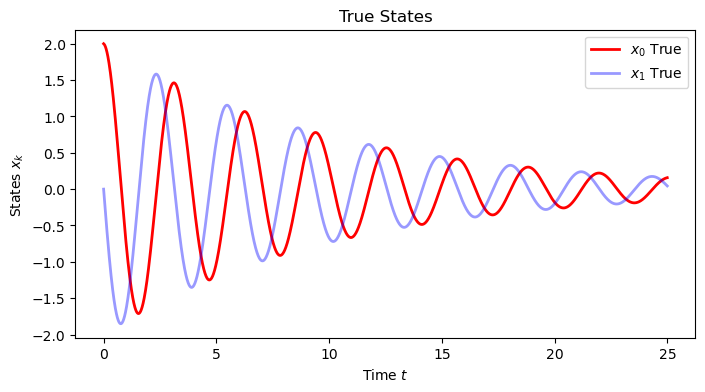

In [17]:
fig, ax = plt.subplots(1, 1, figsize=(8, 4))  # 1 row, 2 columns
ax.plot(t_train, x_train[:, 0], "r", label=r"$x_0$ True ", linewidth=2)
ax.plot(t_train, x_train[:, 1], "b", label=r"$x_1$ True ", alpha=0.4, linewidth=2)
ax.set_xlabel("Time $t$")
ax.set_ylabel(r"States $x_k$")
ax.legend()
ax.set_title("True States")

In [19]:
# Fit the model
degree=5
matrix_theta=Theta(x_train,t_train,degree,True,False,False,False)

In [20]:
print(matrix_theta.shape)

(2500, 36)


In [21]:
# Calculate time derivatives (dx/dt)
dxdt = np.array([np.gradient(x_train[:, i], dt) for i in range(x_train.shape[1])]).T  # shape: (samples, features)

In [22]:
# Fit Adaptive Lasso for each state variable (i.e., for each feature in x_train)
coefficients = np.zeros((matrix_theta.shape[1], x_train.shape[1]))
for i in range(x_train.shape[1]):
    print(f"\nFitting variable {i}:")
    coefficients[:, i] = alasso(matrix_theta, dxdt[:, i], alpha=0.000001)


Fitting variable 0:

Iteration Weight Δ       Coef Δ         L1 Norm        Max Coef       Nonzero Coefs  
--------------------------------------------------------------------------------
0         1.111e+15      1.003e+00      2.143e+00      2.000e+00      32             
1         8.331e+15      1.112e+07      2.101e+00      2.000e+00      2              
2         8.822e-12      9.444e+07      2.101e+00      2.000e+00      2              
3         5.549e-19      9.444e+07      2.101e+00      2.000e+00      2              
Converged after 3 iterations

Fitting variable 1:

Iteration Weight Δ       Coef Δ         L1 Norm        Max Coef       Nonzero Coefs  
--------------------------------------------------------------------------------
0         1.111e+15      1.058e+00      2.126e+00      2.000e+00      32             
1         8.331e+15      1.112e+07      2.101e+00      2.000e+00      2              
2         8.093e-13      9.444e+07      2.101e+00      2.000e+00      2      

In [16]:
print(monomial_exponents(x_train.shape[1],degree))

coefficients

[(0, 0), (0, 1), (0, 2), (0, 3), (0, 4), (0, 5), (1, 0), (1, 1), (1, 2), (1, 3), (1, 4), (1, 5), (2, 0), (2, 1), (2, 2), (2, 3), (2, 4), (2, 5), (3, 0), (3, 1), (3, 2), (3, 3), (3, 4), (3, 5), (4, 0), (4, 1), (4, 2), (4, 3), (4, 4), (4, 5), (5, 0), (5, 1), (5, 2), (5, 3), (5, 4), (5, 5)]


array([[ 0.        ,  0.        ],
       [ 2.00033968, -0.10015674],
       [ 0.        , -0.        ],
       [-0.        ,  0.        ],
       [ 0.        , -0.        ],
       [-0.        ,  0.        ],
       [-0.10016833, -2.00038927],
       [-0.        ,  0.        ],
       [ 0.        , -0.        ],
       [-0.        , -0.        ],
       [-0.        , -0.        ],
       [-0.        , -0.        ],
       [-0.        ,  0.        ],
       [-0.        , -0.        ],
       [ 0.        ,  0.        ],
       [-0.        , -0.        ],
       [ 0.        ,  0.        ],
       [-0.        , -0.        ],
       [-0.        ,  0.        ],
       [-0.        ,  0.        ],
       [ 0.        , -0.        ],
       [-0.        ,  0.        ],
       [ 0.        , -0.        ],
       [-0.        ,  0.        ],
       [-0.        ,  0.        ],
       [-0.        ,  0.        ],
       [ 0.        ,  0.        ],
       [-0.        , -0.        ],
       [ 0.        ,

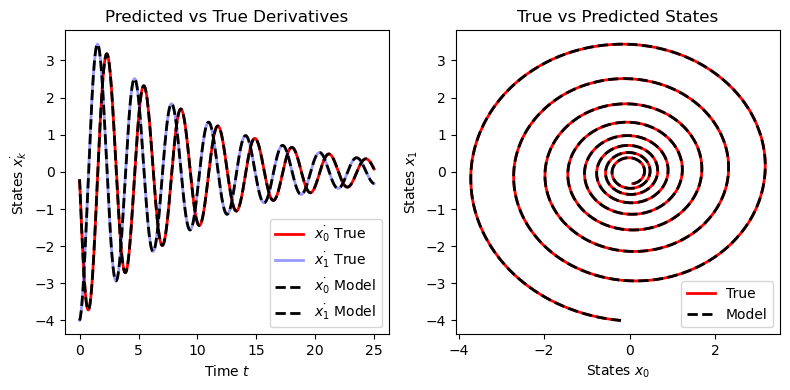

In [21]:
# Actual solution from the original system (x_train)
# Compute Theta_x for all time steps at once (this is the monomial terms for each state)
Theta_x_all = np.array([np.prod(np.power(x_train, power), axis=1) for power in powers]).T  # Shape: (num_samples, num_monomial_terms)

# Predicted derivatives using ve|ctorized matrix multiplication (Theta_x * zeta)
x_sim = np.dot(Theta_x_all, coefficients)  # Shape: (num_samples, num_state_variables)

# Create a figure with 1 row and 2 columns (for side-by-side plots)
fig, ax = plt.subplots(1, 2, figsize=(8, 4))  # 1 row, 2 columns

# First plot: Predicted vs True Derivatives
ax[0].plot(t_train, dxdt[:, 0], "r", label=r"$\dot{x_0}$ True ", linewidth=2)
ax[0].plot(t_train, dxdt[:, 1], "b", label=r"$\dot{x_1}$ True ", alpha=0.4, linewidth=2)
ax[0].plot(t_train, x_sim[:, 0], "k--", label=r"$\dot{x_0}$ Model", linewidth=2)
ax[0].plot(t_train, x_sim[:, 1], "k--", label=r"$\dot{x_1}$ Model", linewidth=2)
ax[0].set_xlabel("Time $t$")
ax[0].set_ylabel(r"States $\dot{x_k}$")
ax[0].legend()
ax[0].set_title("Predicted vs True Derivatives")

# Second plot: True vs Predicted States
ax[1].plot(dxdt[:, 0], dxdt[:, 1], "r", label="True", linewidth=2)
ax[1].plot(x_sim[:, 0], x_sim[:, 1], "k--", label="Model", linewidth=2)
ax[1].set_xlabel(r"States ${x_0}$")
ax[1].set_ylabel(r"States ${x_1}$")
ax[1].legend()
ax[1].set_title("True vs Predicted States")
# Adjust layout for better spacing
plt.tight_layout()
# Show the plots
plt.show()

In [18]:
# Compute the error
error_x0 = np.linalg.norm(x_sim[:, 0] - dxdt[:, 0])
error_x1 = np.linalg.norm(x_sim[:, 1] - dxdt[:, 1])
print(f"Error for x0: {error_x0}")
print(f"Error for x1: {error_x1}")

Error for x0: 0.07153422693097387
Error for x1: 0.06359263278156371
